In [25]:
import numpy as np
import random
import sys
import io
import os
import glob
import IPython
import time
from pydub import AudioSegment
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy import signal
%matplotlib inline
global prevsegs
global datasamples
datasamples = 0

In [2]:
def get_info(file):
    r,d =wavfile.read(file)
    return r,d

In [3]:
def graph(file):
    rate, data = get_info(file)
    n =200                                                                # length of each segment
    f =8000                                                               # sample frequencies
    noverlap=120                                                          # overlap between segments
    channel=data.ndim
    if channel==1:
        pxx, freqs, bins, im=plt.specgram(data,200,8000,noverlap=120)
    elif channel==2:
        pxx, freqs, bins, im=plt.specgram(data[:,0],200,8000,noverlap=120)
    return pxx

array([[3.25856440e+02, 7.62366026e+02, 1.59219081e+02, ...,
        3.78196219e+03, 1.25076173e-01, 1.08215693e+03],
       [2.37173644e+03, 2.42225699e+03, 5.03947505e+02, ...,
        7.73832440e+03, 7.39044429e+02, 9.88433303e+02],
       [1.35826030e+03, 1.28310424e+03, 2.38497188e+02, ...,
        2.91904390e+03, 7.88323094e+02, 8.83835700e+02],
       ...,
       [9.59217670e-05, 7.62692755e-05, 1.71557427e-06, ...,
        1.48610092e-02, 2.58522373e-03, 8.15988113e-03],
       [1.87387436e-04, 9.68949429e-06, 1.66955570e-05, ...,
        2.48121871e-02, 1.37046976e-02, 6.46719510e-03],
       [2.73540933e-04, 8.07624766e-05, 2.53013297e-05, ...,
        7.98687874e-04, 1.58419267e-05, 4.09724139e-07]])

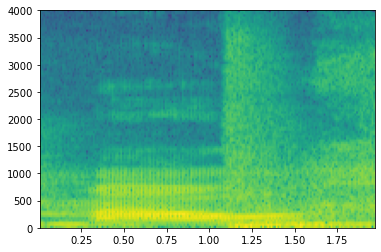

In [4]:
graph('raw_data/negatives/1.wav')

In [5]:
def graph2(file):
    sample_rate, samples = wavfile.read(file)
    frequencies,times,spectrogram = signal.spectrogram(samples,sample_rate)
    plt.pcolormesh(times,frequencies,spectrogram)
    plt.imshow(spectrogram)
    plt.ylabel('frequency[Hz]')
    plt.xlabel('time(sec)')
    plt.show()
    print(sample_rate,samples)

In [6]:
#graph2('raw_data/negatives/1.wav')

In [7]:
Tx = 5511
n_freq = 101
Ty = 1375

In [8]:
def load_raw_audio():
    a = []
    b = []
    n = []
    for f in os.listdir('raw_data/activates/'):
        if f.endswith('.wav'):
            anew = AudioSegment.from_wav('raw_data/activates/'+f)
            a.append(anew)
    for f in os.listdir('raw_data/backgrounds/'):
        if f.endswith('.wav'):
            bnew = AudioSegment.from_wav('raw_data/backgrounds/'+f)
            b.append(bnew)
    for f in os.listdir('raw_data/negatives/'):
        if f.endswith('.wav'):
            nnew = AudioSegment.from_wav('raw_data/negatives/'+f)
            n.append(nnew)
    return a,n,b

In [9]:
a,n,b = load_raw_audio()
for i in range(len(a)):
    #dif = len(a[i])-29025
    #n= dif/2
    #a[i] = a[i][int(n):int(len(a[i])-n)]
    print('activates['+str(i)+']:',str(len(a[i])))
    
print('=====================================================================================')
for i in range(len(n)):
    print('negatives['+str(i)+']:',str(len(n[i])))
print('=====================================================================================')
for i in range(len(b)):
    print('backgroundss['+str(i)+']:',str(len(b[i])))

activates[0]: 721
activates[1]: 731
activates[2]: 1741
activates[3]: 909
activates[4]: 725
activates[5]: 668
activates[6]: 916
activates[7]: 2392
activates[8]: 655
negatives[0]: 360
negatives[1]: 579
negatives[2]: 407
negatives[3]: 541
negatives[4]: 655
negatives[5]: 358
negatives[6]: 552
negatives[7]: 1337
negatives[8]: 355
negatives[9]: 600
backgroundss[0]: 10000
backgroundss[1]: 10000
backgroundss[2]: 10891
backgroundss[3]: 10000
backgroundss[4]: 10000
backgroundss[5]: 10000
backgroundss[6]: 10000


In [10]:
def random_time_segment(time_ms):
    start = np.random.randint(low=0,high=10000-time_ms)
    end = start+time_ms-1
    return (start,end)

In [11]:
def isoverlapping(segtime,prevsegs):
    start,end=segtime
    overlap = False
    for prevstart, prevend in prevsegs:
            if start<=prevend and end>=prevstart:
                overlap = True
    return overlap

In [12]:
def insert(b,clip,prevsegs):
    time_ms = len(clip)
    segtime = random_time_segment(time_ms)
    while isoverlapping(segtime,prevsegs):
        segtime = random_time_segment(time_ms)
    prevsegs.append(segtime)
    newb = b.overlay(clip,position=segtime[0])
    return newb,segtime

In [13]:
def insert_ones(y,segend_ms):
    segend_y = int(segend_ms*Ty/10000)
    for i in range(segend_y+1,segend_y+51):
        if i < Ty:
            y[0,i]=1
    return y

In [14]:
def match_target_amplitude(sound, target_dBFS):
    change= target_dBFS-sound.dBFS
    return sound.apply_gain(change)

In [15]:
def create_train_samples(back,a,n):
    global datasamples
    x=0
    datasamples+=1
    back=back-20
    y=np.zeros((1,Ty))
    prevsegs=[]
    no_a = np.random.randint(0,5)
    random_indices = np.random.randint(low=1,high=len(a),size=no_a)
    random_as = [a[i] for i in random_indices]
    for rand_a in random_as:
        back,segtime = insert(back,rand_a,prevsegs)
        start,end = segtime
        y= insert_ones(y,end)
    no_n = np.random.randint(0,3)
    random_indices = np.random.randint(len(n),size=no_n)
    random_ns=[n[i] for i in random_indices]
    for rand_n in random_ns:
        back,_ = insert(back,rand_n,prevsegs)
    back = match_target_amplitude(back,-20.0)
    name = "train"+str(datasamples)+".wav"
    file_handle= back.export("data/"+name,format="wav")
    print("file "+name+" is saved in to directory.")
    #x = graph("data/"+name)
    return x,y

In [16]:
x,y=create_train_samples(b[0],a,n)

file train1.wav is saved in to directory.


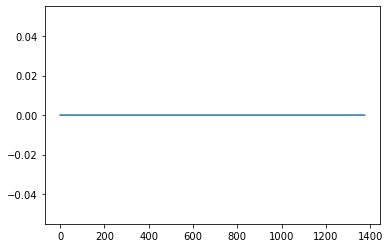

In [17]:
plt.plot(y[0])

In [31]:
def emptydata(path):
  files = glob.glob(path)
  for f in files:
      os.remove(f)

In [32]:
def full_train_set(b,a,n,samples=20):
  global X
  global Y
  X=[]
  Y=[]
  for _ in range(samples):
    random=np.random.randint(1,len(b))
    x,y=create_train_samples(b[random],a,n)
    X.append(x)
    Y.append(y)
    time.sleep(0.5)
    if len(os.listdir('data'))>samples:
      break
    

In [33]:
#datasamples=0
for f in os.listdir('data/'):
  emptydata('data'+f)
full_train_set(b,a,n,samples=500)

file train1.wav is saved in to directory.
file train2.wav is saved in to directory.
file train3.wav is saved in to directory.
file train4.wav is saved in to directory.
file train5.wav is saved in to directory.
file train6.wav is saved in to directory.
file train7.wav is saved in to directory.
file train8.wav is saved in to directory.
file train9.wav is saved in to directory.
file train10.wav is saved in to directory.
file train11.wav is saved in to directory.


KeyboardInterrupt: 

In [ ]:
from keras.callbacks import ModelCheckpoint
from keras.models import Model, load_model, Sequential
from keras.layers import Dense, Activation, Dropout,Input, Masking, TimeDistributed, LSTM, Conv1D,GRU,Bidirectional,Reshape,BatchNormalization
from keras.optimizers import Adam, RMSprop

In [ ]:
def model(input_shape):
    X_input = Input(shape = input_shape)
    
    # CONV layer 
    X = Conv1D(196, kernel_size=15, strides=4)(X_input)                                 
    X = BatchNormalization()(X)                                 
    X = Activation('relu')(X)                                 
    X = Dropout(0.8)(X)                                 

    # First GRU Layer 
    X = GRU(units = 128, return_sequences = True)(X) 
    X = Dropout(0.8)(X)                              
    X = BatchNormalization()(X)                      
    
    # Second GRU Layer 
    X = GRU(units = 128, return_sequences = True)(X) 
    X = Dropout(0.8)(X)                              
    X = BatchNormalization()(X)                      
    X = Dropout(0.8)(X)                              
    
    # Time-distributed dense layer 
    X = TimeDistributed(Dense(1, activation = "sigmoid"))(X) # time distributed  (sigmoid)
    
    model = Model(inputs=X_input,outputs=X)
    return model


In [ ]:
model = model(input_shape=(Tx,n_freq))

In [ ]:
model.summary()